Department of Physics, University of Pisa (AA 2020-2021)

### Multimessenger Physics Laboratory



## Data Analysis experience - Gravitational Waves 
#### (M. Razzano, Apr 24,2021)


### Import

In [1]:
import os 
import sys
import numpy as np #Numerical Python
import matplotlib.pyplot as plt
from astropy.io import fits
from gwosc.datasets import event_gps
from gwosc.locate import get_event_urls
from gwpy.timeseries import TimeSeries
from gwpy.segments import DataQualityFlag
from gwpy.plot import Plot

### Directory


In [2]:
work_dir = os.getcwd()
main_dir =os.path.dirname(work_dir)
data_dir = os.path.join(main_dir,"data")
results_dir = os.path.join(main_dir,"results")
    

### Let's get started
After this basic setup, you are ready to start with the analysis. Enjoy!

In [3]:
ev_name = "GW150914"
ev_ifo = ("H1","L1")


dt_win=3600/4
gps = event_gps(ev_name)
ev_t0_min = gps-dt_win
ev_t0_max = gps+dt_win

class GWData():

    def __init__(self,ev_name,ev_ifo,save=False):
        dt_win=3600/2
        self.gps = event_gps(ev_name)
        ev_t0_min = self.gps-dt_win
        ev_t0_max = self.gps+dt_win
        self.data=self.Data(ev_name,ev_ifo,save)
        self.segment=self.Segment(ev_name,ev_ifo,save)

    class Data():
        def __init__(self,ev_name,ev_ifo,save):        
            for detector in ev_ifo:
                if save==True:
                    exec(f"self.{detector}=TimeSeries.fetch_open_data('{detector}',ev_t0_min,ev_t0_max,cache=True)")
                    exec(f"self.{detector}.write(os.path.join(data_dir,'{ev_name}_{detector}.txt'))")
                else:
                    exec(f"self.{detector}=TimeSeries.read(os.path.join(data_dir,'{ev_name}_{detector}.txt'))")




    class Segment():
        def __init__(self,ev_name,ev_ifo,save):
            for detector in ev_ifo:
                #exec(f"self.{detector}=DataQualityFlag.fetch_open_data('{detector}'+'_DATA',ev_t0_min-dt_win,ev_t0_max+dt_win)")


                if save==True:
                    exec(f"self.{detector}=DataQualityFlag.fetch_open_data('{detector}'+'_DATA',ev_t0_min-dt_win,ev_t0_max+dt_win)")
                    exec(f"self.{detector}.write(os.path.join(data_dir,'{ev_name}_{detector}_segments.json'))")
                else:
                    exec(f"self.{detector}=DataQualityFlag.read(os.path.join(data_dir,'{ev_name}_{detector}_segments.json'))")




In [4]:
gw=GWData(ev_name,ev_ifo)

# Signal Plot

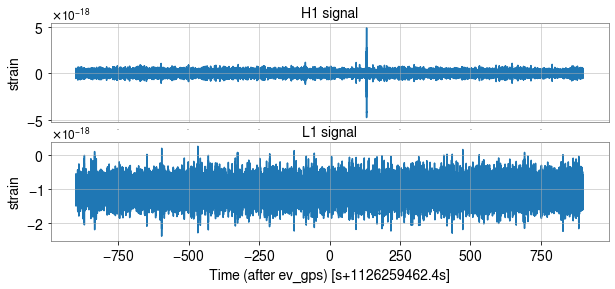

In [5]:
plt.figure(figsize=(10,4))
plt.subplot(211)
plt.plot(gw.data.H1.times.value-gps,gw.data.H1)
plt.title("H1 signal",fontsize=14)
plt.ylabel("strain",fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='x', labelsize=0, length = 0)
plt.subplot(212)
plt.title("L1 signal",fontsize=14)
plt.plot(gw.data.L1.times.value-gps,gw.data.L1)
plt.ylabel("strain",fontsize=14)
plt.xlabel(f"Time (after ev_gps) [s+{gps}s]",fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

## Segment plot

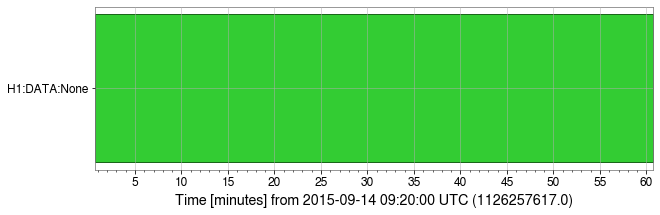

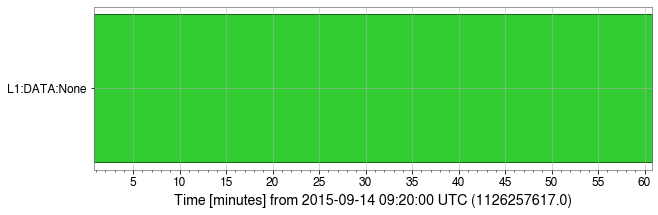

In [6]:
gw.segment.H1.plot(figsize=(10,3))
gw.segment.L1.plot(figsize=(10,3))
print("")

# ASD

(10, 2000)

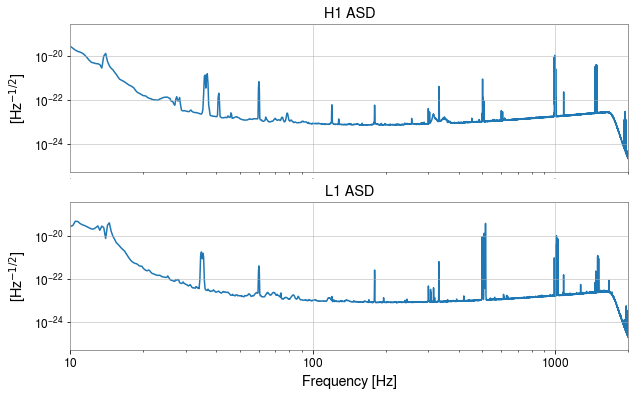

In [7]:
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(gw.data.H1.asd(4).frequencies,gw.data.H1.asd(4))
plt.title("H1 ASD")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("[Hz$^{-1/2}$]")
plt.tick_params(axis='x', labelsize=0, length = 0)
plt.xlim(10,2000)
plt.subplot(212)
plt.plot(gw.data.L1.asd(4).frequencies,gw.data.L1.asd(4))
plt.title("L1 ASD")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency [Hz]")
plt.ylabel("[Hz$^{-1/2}$]")
plt.xlim(10,2000)


## ASD(t)

In [8]:
L1_fft=gw.data.L1.spectrogram2(fftlength=4, overlap=2, window='hann') ** (1/2.)
H1_fft=gw.data.H1.spectrogram2(fftlength=4, overlap=2, window='hann') ** (1/2.)

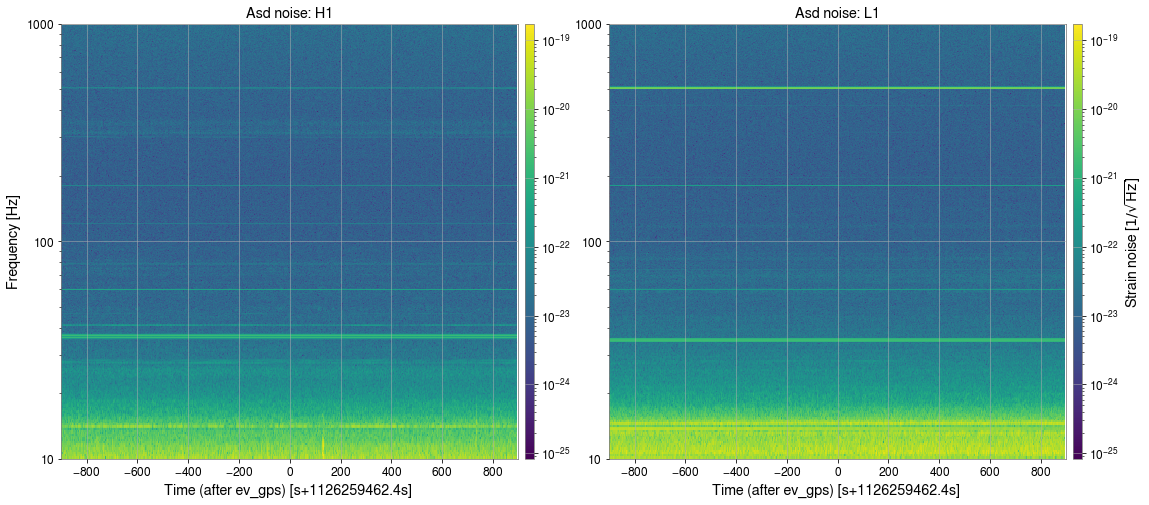

In [9]:
fmax=1000
H1_max=np.amax(H1_fft.value[:,((H1_fft.frequencies.value<fmax) & (H1_fft.frequencies.value>10)  )])
H1_min=np.amin(H1_fft.value[:,((H1_fft.frequencies.value<fmax) & (H1_fft.frequencies.value>10)  )])
L1_max=np.amax(L1_fft.value[:,((L1_fft.frequencies.value<fmax) & (L1_fft.frequencies.value>10)  )])
L1_min=np.amin(L1_fft.value[:,((L1_fft.frequencies.value<fmax) & (L1_fft.frequencies.value>10)  )])
fft_min=min(H1_min,L1_min)
fft_max=max(H1_max,L1_max)


f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]},figsize=(18,8))
a1.imshow(L1_fft,aspect="auto",origin="lower",extent=(L1_fft.times[0].value-gps,L1_fft.times[-1].value-gps,L1_fft.frequencies[0].value,L1_fft.frequencies[-1].value))
a1.colorbar(norm="log",clim=(fft_min,fft_max),label=r"Strain noise [$1/\sqrt{\mathrm{Hz}}$]")
#a1.xlim(20,20)
a1.set_yscale("log")
a1.set_xlabel(f"Time (after ev_gps) [s+{gps}s] ")

a1.set_ylim(10,fmax)
a1.set_title("Asd noise: L1")

a0.imshow(H1_fft,aspect="auto",origin="lower",extent=(H1_fft.times[0].value-gps,H1_fft.times[-1].value-gps,H1_fft.frequencies[0].value,H1_fft.frequencies[-1].value))
a0.set_ylim(10,fmax)
a0.set_yscale("log")
a0.set_title("Asd noise: H1")
a0.set_xlabel(f"Time (after ev_gps) [s+{gps}s] ")
a0.set_ylabel("Frequency [Hz]")
a0.colorbar(norm="log",clim=(fft_min,fft_max))

## std of ASD

In [10]:
from scipy.signal import convolve2d
Hz=10
s=10
sidx=int(s*np.shape(H1_fft.value)[0]/(dt_win*2))
Hzidx=int(Hz*np.shape(H1_fft.value)[1]/(H1_fft.frequencies[-1].value-H1_fft.frequencies[0].value))


Hmean=convolve2d(H1_fft.value,np.ones((sidx,Hzidx)),mode="valid")/(sidx*Hzidx)
Lmean=convolve2d(L1_fft.value,np.ones((sidx,Hzidx)),mode="valid")/(sidx*Hzidx)

Text(0.5, 1.0, '$\\frac{df}{dt}(f,t) $: L1')

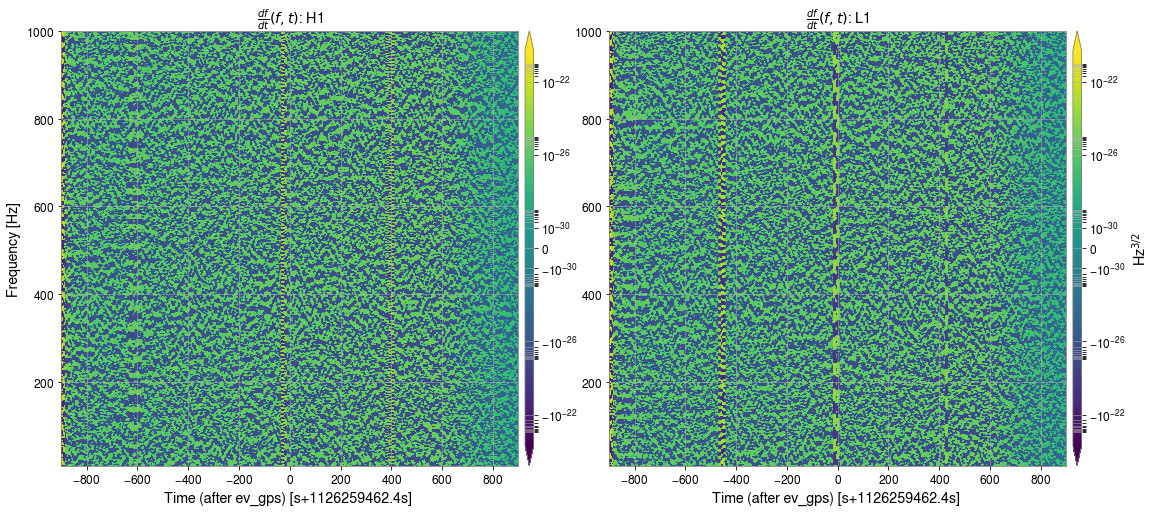

In [11]:
from matplotlib.colors import SymLogNorm
dH=(Hmean[:-1:,:]-Hmean[1::,:])/s
dL=(Lmean[:-1:,:]-Lmean[1::,:])/s

norm = SymLogNorm(1e-30,vmin=-5.2e-21,vmax=5e-21,base=10)


f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]},figsize=(18,8))
a0.imshow((dH),aspect="auto",origin="lower",extent=(L1_fft.times[0].value-gps,L1_fft.times[-1].value-gps,L1_fft.frequencies[0].value,L1_fft.frequencies[-1].value))
a0.colorbar(clim=(-5.2e-21,5e-21), extend='both',norm=norm)
#a0.set_yscale("log")
a0.set_xlabel(f"Time (after ev_gps) [s+{gps}s] ")
a0.set_ylabel("Frequency [Hz]")
a0.set_ylim(10,fmax)
a0.set_title(r"$\frac{df}{dt}(f,t) $: H1")


a1.imshow((dL),aspect="auto",origin="lower",extent=(L1_fft.times[0].value-gps,L1_fft.times[-1].value-gps,L1_fft.frequencies[0].value,L1_fft.frequencies[-1].value))
a1.colorbar(clim=(-5.2e-21,5e-21), extend='both',norm=norm,label=r"Hz$^{3/2}  $")
#a1.set_yscale("log")
a1.set_xlabel(f"Time (after ev_gps) [s+{gps}s] ")
#1.set_ylabel("Frequency [Hz]")
a1.set_ylim(10,fmax)
a1.set_title(r"$\frac{df}{dt}(f,t) $: L1")

Text(0, 0.5, 'Standard deviation [$1/\\sqrt{\\mathrm{Hz}}$]')

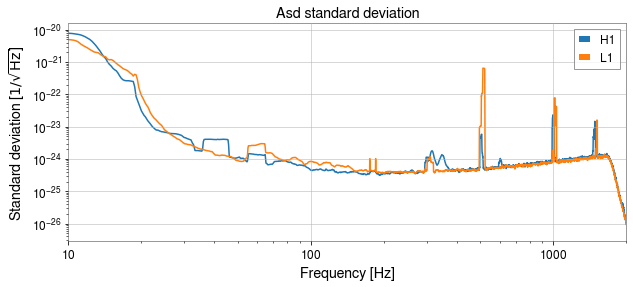

In [12]:
Hstd=np.std(Hmean,axis=0)
Lstd=np.std(Lmean,axis=0)
f_limit=int((len(H1_fft.frequencies)-len(Hstd))/2)
plt.figure(figsize=(10,4))
plt.xlim(10,2000)
plt.xscale("log")
plt.yscale("log")
plt.plot(H1_fft.frequencies.value[f_limit:-f_limit-1],Hstd,label="H1")

plt.plot(L1_fft.frequencies.value[f_limit:-f_limit-1],Lstd,label="L1")
plt.legend()
plt.title("Asd standard deviation")
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"Standard deviation [$1/\sqrt{\mathrm{Hz}}$]")

# Signal 

## Raw

Text(0.5, 0, 'Time [s]')

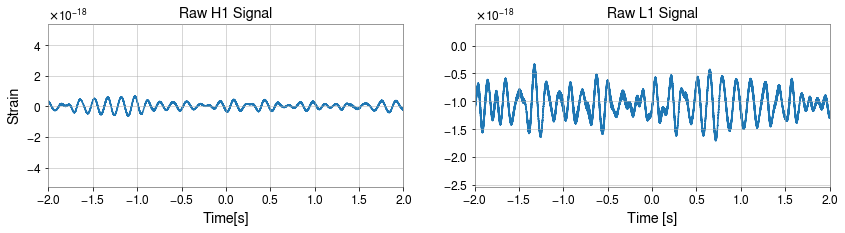

In [13]:

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]},figsize=(14,3))
a0.plot(gw.data.H1.times.value-gps,gw.data.H1.value)
a0.set_xlim(-2,2)
a0.set_title("Raw H1 Signal")
a0.set_ylabel("Strain")
a0.set_xlabel("Time[s]")

a1.plot(gw.data.L1.times.value-gps,gw.data.L1.value)
a1.set_title("Raw L1 Signal")
a1.set_xlim(-2,2)
a1.set_xlabel("Time [s]")

## Notched

In [14]:

L1_filtered=gw.data.H1.bandpass(50,300).notch(60)
H1_filtered=gw.data.H1.bandpass(50,300).notch(60)
#notch a 60 poichè in USA la rete di alimentazione è a 60 Hz


Text(0.5, 0, 'Time [s]')

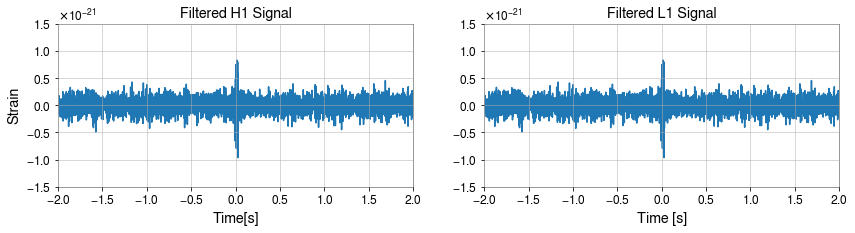

In [15]:

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]},figsize=(14,3))
a0.plot(gw.data.H1.times.value-gps,H1_filtered)
a0.set_xlim(-2,2)
a0.set_title("Filtered H1 Signal")
a0.set_ylabel("Strain")
a0.set_xlabel("Time[s]")
a0.set_ylim(-0.15e-20,0.15e-20)
a1.plot(gw.data.L1.times.value-gps,L1_filtered)
a1.set_title("Filtered L1 Signal")
a1.set_xlim(-2,2)
a1.set_ylim(-0.15e-20,0.15e-20)
a1.set_xlabel("Time [s]")

Text(0.5, 0, 'Time [s]')

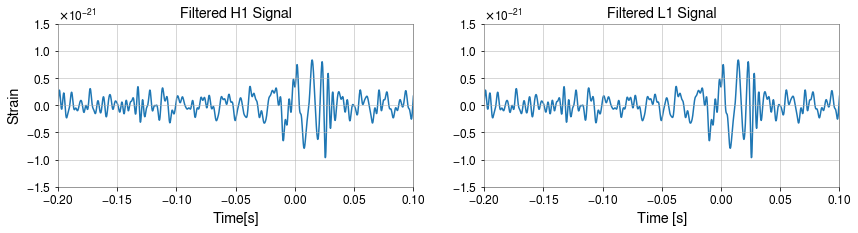

In [16]:
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]},figsize=(14,3))
a0.plot(gw.data.H1.times.value-gps,H1_filtered)
a0.set_xlim(-0.2,0.1)
a0.set_title("Filtered H1 Signal")
a0.set_ylabel("Strain")
a0.set_xlabel("Time[s]")
a0.set_ylim(-0.15e-20,0.15e-20)
a1.plot(gw.data.L1.times.value-gps,L1_filtered)
a1.set_title("Filtered L1 Signal")
a1.set_xlim(-0.2,0.1)
a1.set_ylim(-0.15e-20,0.15e-20)
a1.set_xlabel("Time [s]")

## QT

In [17]:
L1_qt=gw.data.L1.q_transform(frange=(20,550),outseg=(gps-0.2,gps+0.1))

In [18]:
H1_qt=gw.data.H1.q_transform(frange=(20,550),outseg=(gps-0.2,gps+0.1))


<Figure size 1440x360 with 0 Axes>

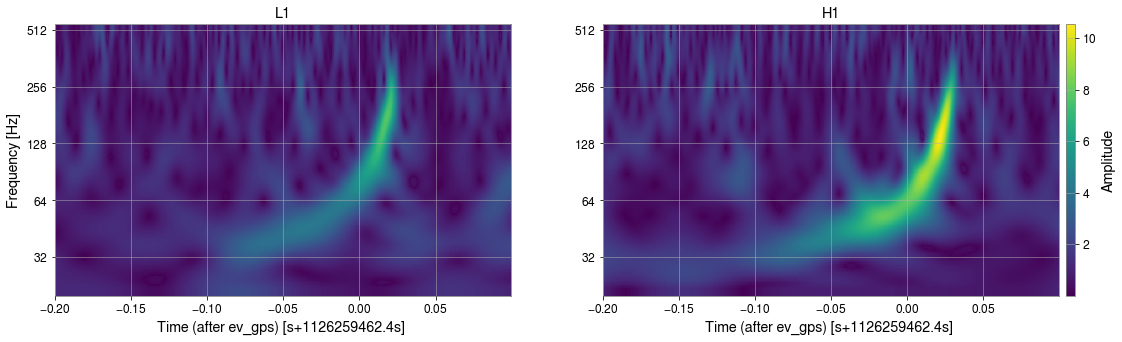

In [19]:
plt.figure(figsize=(20,5))
#plt.subplot(121)
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]},figsize=(18,5))
a0.imshow(abs(L1_qt)**(1/2),aspect="auto",origin="lower",extent=(L1_qt.times[0].value-gps,L1_qt.times[-1].value-gps,20,550),vmax=10.55)
#a0.xlim(-20,20)
a0.set_yscale("log",base=2)
a0.set_xlabel(f"Time (after ev_gps) [s+{gps}s] ")
a0.set_ylabel("Frequency [Hz]")
a0.set_title("L1")

a1.imshow(abs(H1_qt)**(1/2),aspect="auto",origin="lower",extent=(H1_qt.times[0].value-gps,H1_qt.times[-1].value-gps,20,550),vmax=10.55)
#a1.xlim(-20,20)
a1.set_yscale("log",base=2)
a1.set_title("H1")
a1.set_xlabel(f"Time (after ev_gps) [s+{gps}s] ")

a1.colorbar(label="Amplitude")

# Glitch

Text(0, 0.5, 'strain')

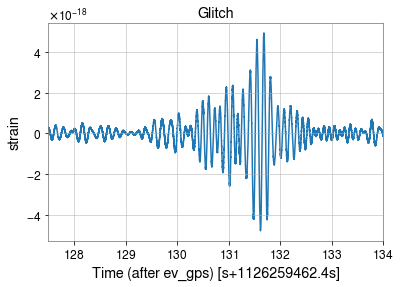

In [20]:
plt.plot(gw.data.H1.times.value-gps,gw.data.H1)
plt.xlim(127.5,134)
plt.title("Glitch")
plt.xlabel(f"Time (after ev_gps) [s+{gps}s]")
plt.ylabel("strain")

In [21]:
H1_glitch=gw.data.H1.q_transform(frange=(0.005,40),outseg=(gps+127.5,gps+134))

Text(0, 0.5, 'Frequency [Hz]')

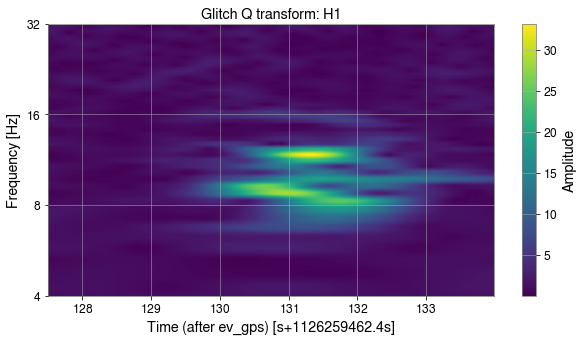

In [22]:
plt.figure(figsize=(10,5))
plt.imshow(abs(H1_glitch)**(1/2),aspect="auto",origin="lower",extent=(H1_glitch.times[0].value-gps,H1_glitch.times[-1].value-gps,0.005,40))
#plt.xlim(-20,20)
plt.yscale("log",base=2)
plt.ylim(4,32)
plt.colorbar(label="Amplitude")
plt.title("Glitch Q transform: H1")
plt.xlabel(f"Time (after ev_gps) [s+{gps}s]")
plt.ylabel("Frequency [Hz]")

In [23]:
print("It seems caused by scattered light")

It seems caused by scattered light


# Match filtering

In [141]:
import pylab
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation


dt_crop=((gw.data.H1.times.value[-1]-gw.data.H1.times.value[0])/2)-15
#dt_crop=2
H1_cbc=resample_to_delta_t(highpass(gw.data.H1.to_pycbc(),15),1/2048).crop(dt_crop,dt_crop)
L1_cbc=resample_to_delta_t(highpass(gw.data.L1.to_pycbc(),15),1/2048).crop(dt_crop,dt_crop)




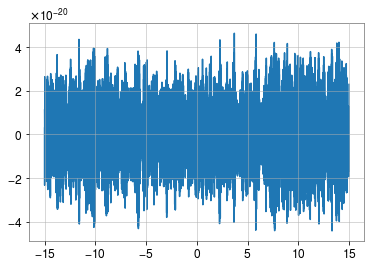

In [142]:
plt.plot(H1_cbc.sample_times-gps,H1_cbc)

In [143]:
H1_psd = interpolate(H1_cbc.psd(4), H1_cbc.delta_f)
H1_psd=inverse_spectrum_truncation(H1_psd, int(4 * H1_cbc.sample_rate),low_frequency_cutoff=15)
L1_psd = interpolate(L1_cbc.psd(4), L1_cbc.delta_f)
L1_psd=inverse_spectrum_truncation(L1_psd, int(4 * L1_cbc.sample_rate),low_frequency_cutoff=15)

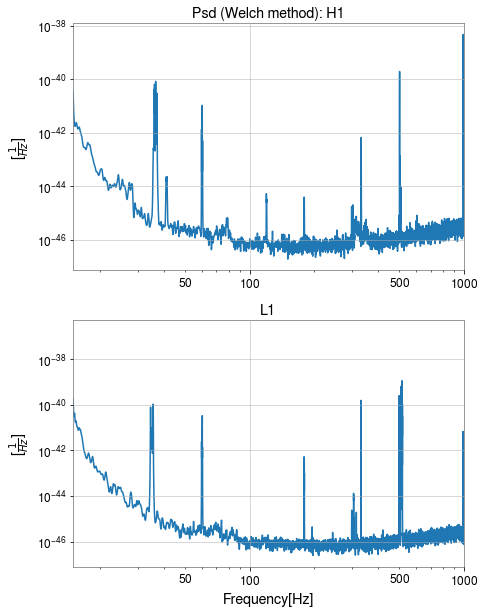

In [144]:
plt.figure(figsize=(7,10))
plt.subplot(211)
plt.plot(H1_psd.sample_frequencies,H1_psd)
plt.xlim(15,1000)
plt.title("Psd (Welch method): H1")
plt.xscale("log")
plt.ylabel(r"[$\frac{1}{Hz}$]")
plt.yscale("log")
plt.subplot(212)
plt.plot(L1_psd.sample_frequencies,L1_psd)
plt.xlim(15,1000)
plt.xscale("log")
plt.title("L1")
plt.ylabel(r"[$\frac{1}{Hz}$]")
plt.xlabel("Frequency[Hz]")
plt.yscale("log")
plt.show()

In [145]:
n=30
m=np.linspace(25,40,n)


sim=np.zeros((n,n), dtype=object)
H1_max_snr=np.zeros((n,n), dtype=object)
H1_snr=np.zeros((n,n), dtype=object)
H1_max_snr=np.zeros((n,n))
L1_max_snr=np.zeros((n,n), dtype=object)
L1_snr=np.zeros((n,n), dtype=object)
L1_max_snr=np.zeros((n,n))

for m2idx,m2 in enumerate(m):
    for m1idx,m1 in enumerate(m):
        if m1>=m2:
            sim[m1idx,m2idx]=get_td_waveform(approximant="SEOBNRv4_opt",mass1=m1,mass2=m2,delta_t=H1_cbc.delta_t,f_lower=20)[0]
            sim[m1idx,m2idx].resize(len(H1_cbc))
            sim[m1idx,m2idx]=sim[m1idx,m2idx].cyclic_time_shift(sim[m1idx,m2idx].start_time)
            H1_snr[m1idx,m2idx]=matched_filter(sim[m1idx,m2idx], H1_cbc,psd=H1_psd, low_frequency_cutoff=20).crop(4,4)
            L1_snr[m1idx,m2idx]=matched_filter(sim[m1idx,m2idx], L1_cbc,psd=L1_psd, low_frequency_cutoff=20).crop(4,4)
            H1_max_snr[m1idx,m2idx]=np.max(np.abs(np.array(H1_snr[m1idx,m2idx])))
            H1_max_snr[m2idx,m1idx]=H1_max_snr[m1idx,m2idx]
            L1_max_snr[m1idx,m2idx]=np.max(np.abs(np.array(L1_snr[m1idx,m2idx])))
            L1_max_snr[m2idx,m1idx]=L1_max_snr[m1idx,m2idx]


Text(0, 0.5, '$M_1 [m_\\odot]$')

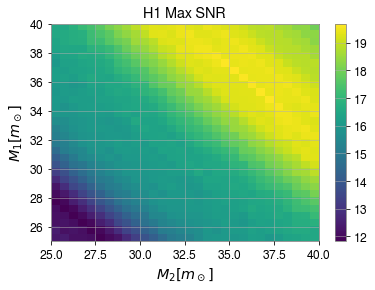

In [146]:
plt.imshow(H1_max_snr,origin="lower",aspect="auto",extent=(m[0],m[-1],m[0],m[-1]))
plt.colorbar()
plt.title("H1 Max SNR")
plt.xlabel("$M_2[m_\odot]$")
plt.ylabel("$M_1 [m_\odot]$")

Text(0, 0.5, 'SNR')

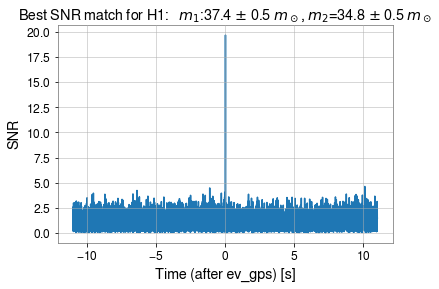

In [147]:
m2_H1_idx,m1_H1_idx=np.unravel_index(H1_max_snr.argmax(), H1_max_snr.shape)
plt.plot(H1_cbc.crop(4,4).sample_times-gps,np.abs(H1_snr[m1_H1_idx,m2_H1_idx]))

plt.title(f"Best SNR match for H1:   $m_1$:{m[m1_H1_idx]:.1f} $ \pm $ {(m[-1]-m[0])/n:.1f} $m_\odot$, $m_2$={m[m2_H1_idx]:.1f} $\pm$ {(m[-1]-m[0])/n:.1f} $m_\odot$")
plt.xlabel("Time (after ev_gps) [s]")
plt.ylabel("SNR")


Text(0, 0.5, '$M_1 [m_\\odot]$')

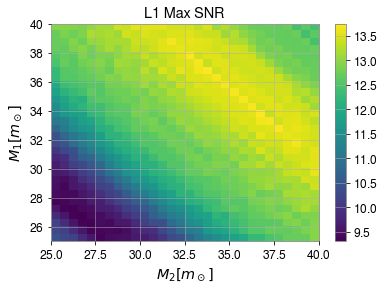

In [148]:
plt.imshow(L1_max_snr,origin="lower",aspect="auto",extent=(m[0],m[-1],m[0],m[-1]))
plt.colorbar()
plt.title("L1 Max SNR")
plt.xlabel("$M_2[m_\odot]$")
plt.ylabel("$M_1 [m_\odot]$")

Text(0, 0.5, 'SNR')

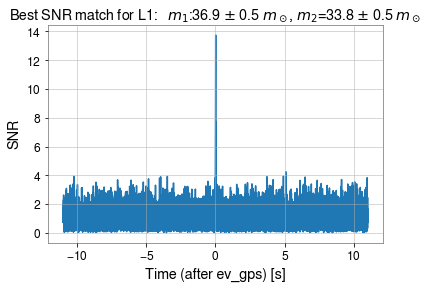

In [152]:
m2_L1_idx,m1_L1_idx=np.unravel_index(L1_max_snr.argmax(), L1_max_snr.shape)
plt.plot(H1_cbc.crop(4,4).sample_times-gps,np.abs(L1_snr[m1_L1_idx,m2_L1_idx]))

plt.title(f"Best SNR match for L1:   $m_1$:{m[m1_L1_idx]:.1f} $ \pm $ {(m[-1]-m[0])/n:.1f} $m_\odot$, $m_2$={m[m2_L1_idx]:.1f} $\pm$ {(m[-1]-m[0])/n:.1f} $m_\odot$")
plt.xlabel("Time (after ev_gps) [s]")
plt.ylabel("SNR")

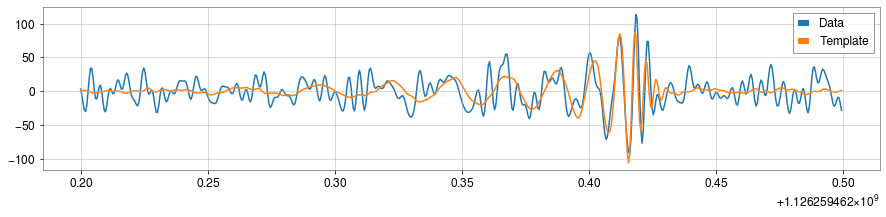

In [150]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = L1_snr[m1_L1_idx,m2_L1_idx].sample_times[np.argmax(L1_snr[m1_L1_idx,m2_L1_idx])] - L1_cbc.start_time
aligned = sim[m1_L1_idx,m2_L1_idx].cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=L1_psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * np.max(L1_max_snr)).to_timeseries()
aligned.start_time = L1_cbc.start_time
# We do it this way so that we can whiten (i.e. normalize the signal to the PSD) both the template and the data

white_data = (L1_cbc.to_frequencyseries() / L1_psd**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / L1_psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(gps-.2, gps+.1)
white_template = white_template.time_slice(gps-.2, gps+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

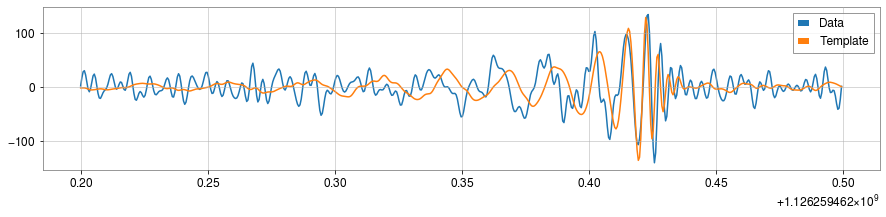

In [151]:
dt = H1_snr[m1_H1_idx,m2_H1_idx].sample_times[np.argmax(H1_snr[m1_H1_idx,m2_H1_idx])] - H1_cbc.start_time
aligned = sim[m1_H1_idx,m2_H1_idx].cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=H1_psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * np.max(H1_max_snr)).to_timeseries()
aligned.start_time = H1_cbc.start_time
# We do it this way so that we can whiten (i.e. normalize the signal to the PSD) both the template and the data

white_data = (H1_cbc.to_frequencyseries() / H1_psd**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / H1_psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(gps-.2, gps+.1)
white_template = white_template.time_slice(gps-.2, gps+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

array([25.        , 25.51724138, 26.03448276, 26.55172414,
       27.06896552, 27.5862069 , 28.10344828, 28.62068966,
       29.13793103, 29.65517241, 30.17241379, 30.68965517,
       31.20689655, 31.72413793, 32.24137931, 32.75862069,
       33.27586207, 33.79310345, 34.31034483, 34.82758621,
       35.34482759, 35.86206897, 36.37931034, 36.89655172,
       37.4137931 , 37.93103448, 38.44827586, 38.96551724,
       39.48275862, 40.        ])